In [1]:
import os
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
# Preprocessing Libraries
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipelines
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


# Model Evaluation Libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

df = pd.read_csv('/Users/jennyr/Downloads/retail_sales_dataset.csv')
display(df.head())


,Transaction ID,Date,Customer ID,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount
0,1,2023-11-24,CUST001,Male,34,Beauty,3,50,150
1,2,2023-02-27,CUST002,Female,26,Clothing,2,500,1000
2,3,2023-01-13,CUST003,Male,50,Electronics,1,30,30
3,4,2023-05-21,CUST004,Male,37,Clothing,1,500,500
4,5,2023-05-06,CUST005,Male,30,Beauty,2,50,100


In [2]:
## Inspect data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Date              1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   Price per Unit    1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [3]:
## Inspect shape, missing values, and duplicates and more
# 1. Shape
print(f"Shape of the dataset: {df.shape}")

# 2. Missing values
print(f"Missing values in the dataset:\n{df.isnull().sum()}")

# 3. Duplicates
print(f"Number of duplicate rows: {df.duplicated().sum()}")

# 4. Negative or zero checks
print((df['Quantity'] <= 0).sum(), 'bad quantities')
print((df['Price per Unit'] <= 0).sum(), 'bad prices')

# 5. Age range
min_age = df['Age'].min()
max_age = df['Age'].max()
print(f"Age range: {min_age} to {max_age}")



Shape of the dataset: (1000, 9)
Missing values in the dataset:
Transaction ID      0
Date                0
Customer ID         0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64
Number of duplicate rows: 0
0 bad quantities
0 bad prices
Age range: 18 to 64


In [4]:
# Initial transaction count
# 6. Transaction count by gender
gender_counts = df['Gender'].value_counts()
print("Transaction counts by gender:")
print(gender_counts)

# 7. Transaction count by product category
category_counts = df['Product Category'].value_counts()
print("Transaction counts by product category:")
print(category_counts)

# 8. Transaction count by age group
age_counts = df['Age'].value_counts()
print("Transaction counts by age:")
print(age_counts)

Transaction counts by gender:
Gender
Female    510
Male      490
Name: count, dtype: int64
Transaction counts by product category:
Product Category
Clothing       351
Electronics    342
Beauty         307
Name: count, dtype: int64
Transaction counts by age:
Age
43    31
64    31
57    30
51    30
34    28
54    28
22    27
62    27
42    26
47    26
46    25
23    24
40    24
50    23
27    23
52    22
60    22
30    22
26    22
31    22
35    22
28    21
41    21
18    21
55    21
20    21
19    21
21    20
25    20
49    19
56    19
32    19
38    19
61    18
39    18
48    18
63    17
45    17
59    17
53    17
29    16
37    16
36    15
44    15
24    15
58    14
33    10
Name: count, dtype: int64


In [5]:
# Checking if necessary to optimize transaction IDs and customer IDs
# Check for unique values in ID columns
n = len(df)
print(f"Unique Transaction IDs: {df['Transaction ID'].nunique()} out of {n}")
print(f"Unique Customer IDs: {df['Customer ID'].nunique()} out of {n}")


Unique Transaction IDs: 1000 out of 1000
Unique Customer IDs: 1000 out of 1000


In [6]:
## Clean Data
# Strip leading/trailing whitespace and convert to title case
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.strip().str.title()
    

In [7]:
# Convert date column to datetime format and set it as index
# 1. Parse dates
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# 2. (Optional) make it the index for time-series work
df.set_index('Date', inplace=True)

# 3. Quick checks
print(df.info())         # confirm dtypes
print(df.describe())     # numeric summary
print(df['Product Category'].value_counts())    # count per category
print(df.groupby('Product Category')['Total Amount'].sum())  # revenue by category

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2023-11-24 to 2023-04-12
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Transaction ID    1000 non-null   int64 
 1   Customer ID       1000 non-null   object
 2   Gender            1000 non-null   object
 3   Age               1000 non-null   int64 
 4   Product Category  1000 non-null   object
 5   Quantity          1000 non-null   int64 
 6   Price per Unit    1000 non-null   int64 
 7   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 70.3+ KB
None
       Transaction ID         Age     Quantity  Price per Unit  Total Amount
count     1000.000000  1000.00000  1000.000000     1000.000000   1000.000000
mean       500.500000    41.39200     2.514000      179.890000    456.000000
std        288.819436    13.68143     1.132734      189.681356    559.997632
min          1.000000    18.00000     1.000000      

In [8]:
# Check date range
start_date = df.index.min()
end_date   = df.index.max()
print(f"Date range: {start_date.date()} to {end_date.date()}")

Date range: 2023-01-01 to 2024-01-01


In [21]:
# Dates of January 2024 transactions:
jan24_df = df.loc['2024-01']

# To just see the unique dates that occur:
unique_dates = jan24_df.index.date
print(unique_dates)

[]


In [22]:
# Remove all rows where the index month is Jan 2024
df = df[~(df.index.to_period('M') == '2024-01')]

# Quick check
print("New date range:", df.index.min().date(), "to", df.index.max().date())

New date range: 2023-01-01 to 2023-12-31


In [9]:
# Check for outliers in 'Total Amount'
# Compute Q1, Q3, and IQR for Total Amount
Q1 = df['Total Amount'].quantile(0.25)
Q3 = df['Total Amount'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
lo_outliers = df[df['Total Amount'] < lower_bound].shape[0]
hi_outliers = df[df['Total Amount'] > upper_bound].shape[0]

print(f"IQR method → lower bound: {lower_bound}, upper bound: {upper_bound}")
print(f"Number of lower outliers: {lo_outliers}")
print(f"Number of upper outliers: {hi_outliers}")

IQR method → lower bound: -1200.0, upper bound: 2160.0
Number of lower outliers: 0
Number of upper outliers: 0


In [10]:
# Check outliers in Price per Unit
summary = []
for category, grp in df.groupby('Product Category'):
    Q1 = grp['Price per Unit'].quantile(0.25)
    Q3 = grp['Price per Unit'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_low = (grp['Price per Unit'] < lower).sum()
    n_high = (grp['Price per Unit'] > upper).sum()
    summary.append({
        'Category':       category,
        'Q1':             Q1,
        'Q3':             Q3,
        'IQR':            IQR,
        'Lower Bound':    lower,
        'Upper Bound':    upper,
        'Lower Outliers': n_low,
        'Upper Outliers': n_high
    })

outlier_df = pd.DataFrame(summary).set_index('Category')
print(outlier_df)

               Q1     Q3    IQR  Lower Bound  Upper Bound  Lower Outliers  \
Category                                                                    
Beauty       30.0  300.0  270.0       -375.0        705.0               0   
Clothing     30.0  300.0  270.0       -375.0        705.0               0   
Electronics  30.0  300.0  270.0       -375.0        705.0               0   

             Upper Outliers  
Category                     
Beauty                    0  
Clothing                  0  
Electronics               0  


In [11]:
# Check outliers in Quantity
summary = []

for category, grp in df.groupby('Product Category'):
    Q1 = grp['Quantity'].quantile(0.25)
    Q3 = grp['Quantity'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    n_low = (grp['Quantity'] < lower).sum()
    n_high = (grp['Quantity'] > upper).sum()
    summary.append({
        'Category':       category,
        'Q1':             Q1,
        'Q3':             Q3,
        'IQR':            IQR,
        'Lower Bound':    lower,
        'Upper Bound':    upper,
        'Lower Outliers': n_low,
        'Upper Outliers': n_high
    })

outlier_df = pd.DataFrame(summary).set_index('Category')
print(outlier_df)

              Q1   Q3  IQR  Lower Bound  Upper Bound  Lower Outliers  \
Category                                                               
Beauty       2.0  3.0  1.0         0.50         4.50               0   
Clothing     1.5  4.0  2.5        -2.25         7.75               0   
Electronics  1.0  4.0  3.0        -3.50         8.50               0   

             Upper Outliers  
Category                     
Beauty                    0  
Clothing                  0  
Electronics               0  


/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/4096898762.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.Grouper(freq='M'),


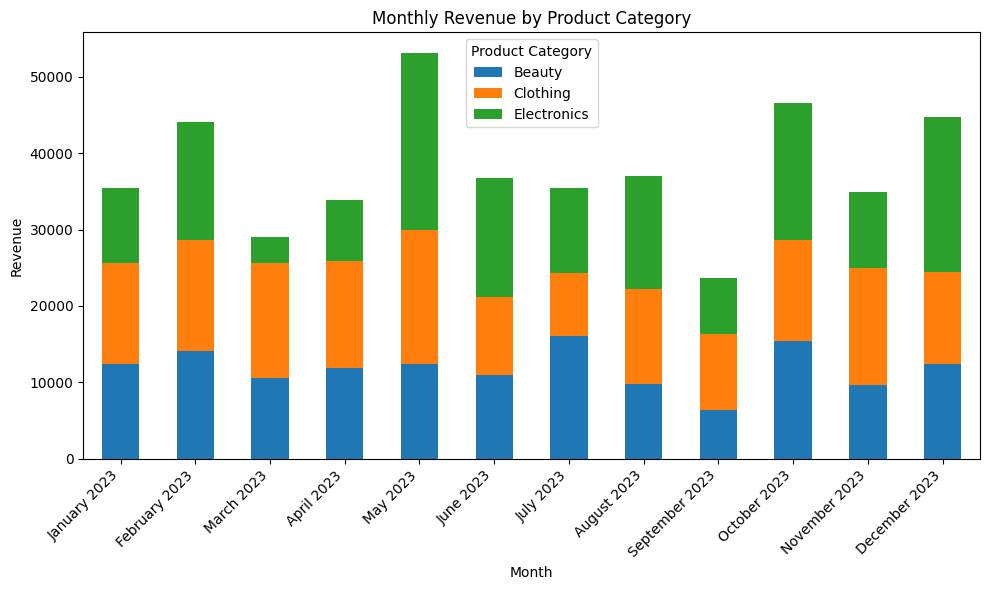

In [23]:
# Explore the data
# Plot the data for monthly sales trends

# Build monthly revenue by category
monthly_rev = df.pivot_table(
    index=pd.Grouper(freq='M'),
    columns='Product Category',
    values='Total Amount',
    aggfunc='sum'
)

# Turn the DatetimeIndex into “Month Year” strings on monthly_rev
monthly_rev.index = monthly_rev.index.strftime('%B %Y')

# Plot a stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
monthly_rev.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Monthly Revenue by Product Category')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/3620328884.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('AgeGroup')['Total Amount'].sum()


AgeGroup
18–24     73335
25–34     98480
35–44     91870
45–54    100690
55–64     80410
Name: Total Amount, dtype: int64

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/2066778686.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.Grouper(freq='M'),


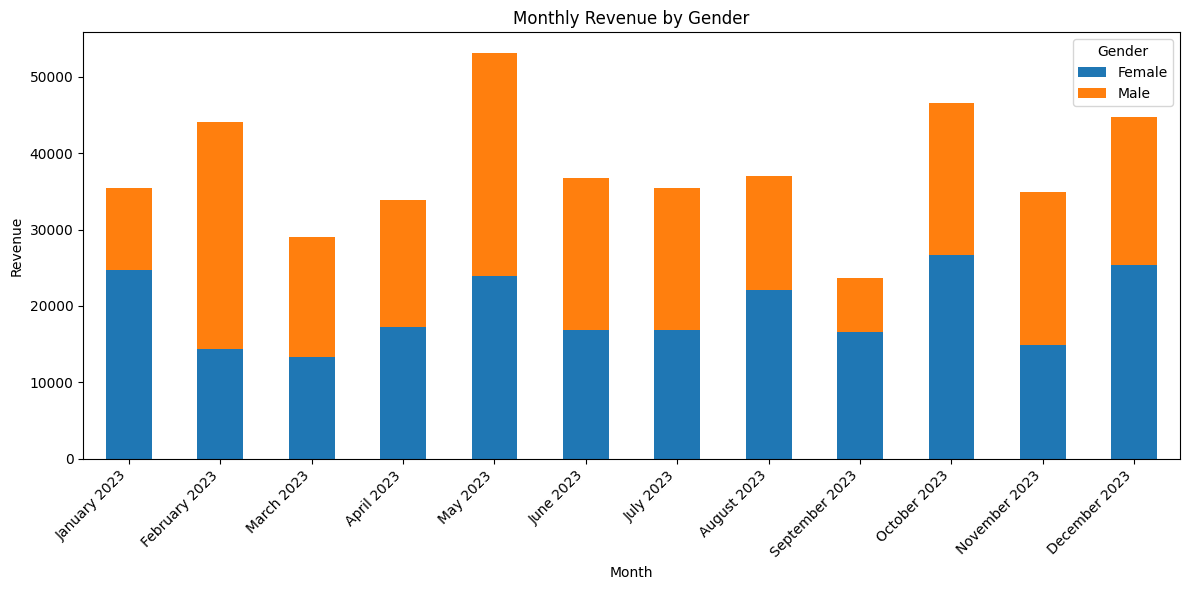

In [26]:
# Monthly revenue by Gender
monthly_gender = df.pivot_table(
    index=pd.Grouper(freq='M'),
    columns='Gender',
    values='Total Amount',
    aggfunc='sum',
    fill_value=0
)
monthly_gender.index = monthly_gender.index.strftime('%B %Y')

fig2, ax2 = plt.subplots(figsize=(12, 6))
monthly_gender.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Monthly Revenue by Gender')
ax2.set_xlabel('Month')
ax2.set_ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
# Group age by generation
bins = [18, 25, 35, 45, 55, 65]
labels = ['18–24','25–34','35–44','45–54','55–64']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
df.groupby('AgeGroup')['Total Amount'].sum()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/2325115771.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('AgeGroup')['Total Amount'].sum()


AgeGroup
18–24     73335
25–34     98480
35–44     90370
45–54    100660
55–64     80410
Name: Total Amount, dtype: int64

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/4174194661.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.Grouper(freq='M'),
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/4174194661.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  monthly_age = df.pivot_table(


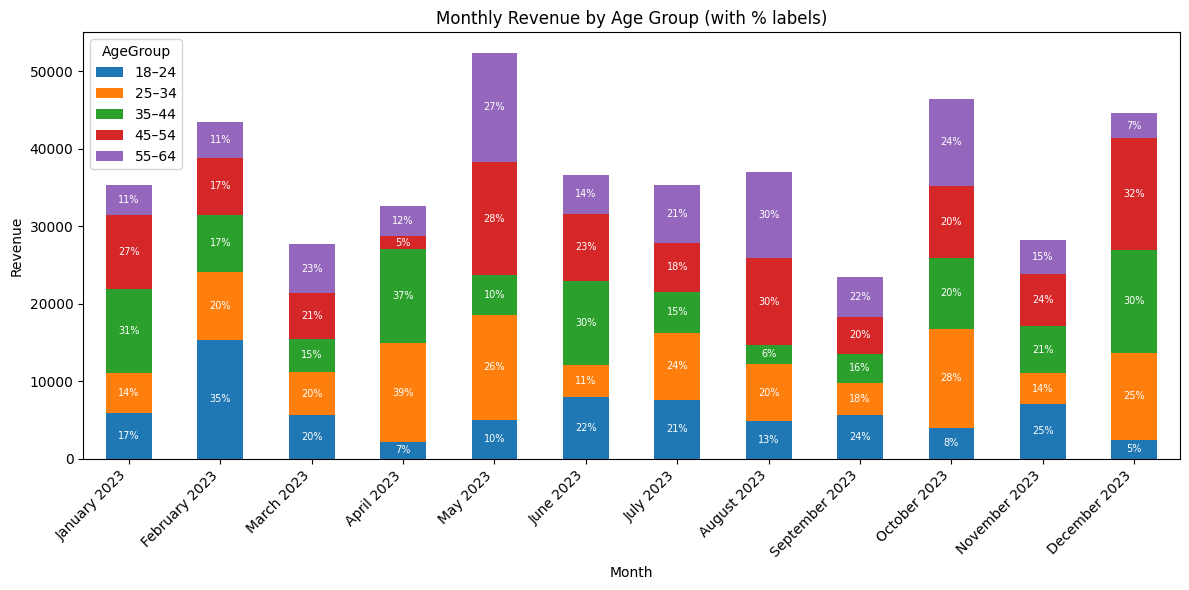

In [30]:
import matplotlib.pyplot as plt

# 1. Pivot monthly revenue by AgeGroup (assumes df already loaded & AgeGroup defined)
monthly_age = df.pivot_table(
    index=pd.Grouper(freq='M'),
    columns='AgeGroup',
    values='Total Amount',
    aggfunc='sum',
    fill_value=0
)

# 2. Format the index for display
monthly_age.index = monthly_age.index.strftime('%B %Y')

# 3. Compute percentages per month
monthly_pct = monthly_age.div(monthly_age.sum(axis=1), axis=0) * 100

# 4. Plot the stacked bars
fig, ax = plt.subplots(figsize=(12, 6))
bars = monthly_age.plot(kind='bar', stacked=True, ax=ax)

# 5. Annotate each stack
for container, age_group in zip(ax.containers, monthly_age.columns):
    # container holds all the bars for one age group
    for bar, pct in zip(container, monthly_pct[age_group]):
        if bar.get_height() > 0:  # skip zero‐height segments
            ax.text(
                bar.get_x() + bar.get_width()/2,             # x-position: center of the bar
                bar.get_y() + bar.get_height()/2,            # y-position: middle of the segment
                f"{pct:.0f}%",                               # label text
                ha='center', va='center', color='white',     # centered in the segment
                fontsize=7
            )

# 6. Final formatting
ax.set_title('Monthly Revenue by Age Group (with % labels)')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [13]:
from pandas.api.types import CategoricalDtype
## Transformations

# Engineer date features
df['Year'] = df.index.year
df['Month'] = df.index.month
df['Day'] = df.index.day
df['Day of Week'] = df.index.dayofweek
df['Is Weekend'] = df['Day of Week'].isin([5, 6])  # Saturday=5, Sunday=6

# Map months to seasons
month_to_season = {
    1: 'Winter',  2: 'Winter',  3: 'Spring',
    4: 'Spring',  5: 'Spring',  6: 'Summer',
    7: 'Summer',  8: 'Summer',  9: 'Fall',
    10: 'Fall',   11: 'Fall',   12: 'Winter'
}
df['Season'] = df.index.month.map(month_to_season)

# 4. Make Season an ordered categorical
season_cat = CategoricalDtype(['Winter','Spring','Summer','Fall'], ordered=True)
df['Season'] = df['Season'].astype(season_cat)

# 5. View table
print(df.head())

            Transaction ID Customer ID  Gender  Age Product Category  \
Date                                                                   
2023-11-24               1     Cust001    Male   34           Beauty   
2023-02-27               2     Cust002  Female   26         Clothing   
2023-01-13               3     Cust003    Male   50      Electronics   
2023-05-21               4     Cust004    Male   37         Clothing   
2023-05-06               5     Cust005    Male   30           Beauty   

            Quantity  Price per Unit  Total Amount  Year  Month  Day  \
Date                                                                   
2023-11-24         3              50           150  2023     11   24   
2023-02-27         2             500          1000  2023      2   27   
2023-01-13         1              30            30  2023      1   13   
2023-05-21         1             500           500  2023      5   21   
2023-05-06         2              50           100  2023      5

In [ ]:
# 1) Define AgeGroup by generation
bins_age   = [18, 25, 35, 45, 55, 65]
labels_age = ['18–24','25–34','35–44','45–54','55–64']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins_age, labels=labels_age, right=False)

# 2) Define Generation cohorts
bins_gen   = [0, 24, 40, 56, 100]
labels_gen = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers']
df['Generation'] = pd.cut(df['Age'], bins=bins_gen, labels=labels_gen, right=True)

# 3) Cross‐tabulate to see alignment
alignment = pd.crosstab(df['AgeGroup'], df['Generation'], dropna=False)
print(alignment)

Generation  Gen Z  Millennials  Gen X  Baby Boomers
AgeGroup                                           
18–24         149            0      0             0
25–34           0          203      0             0
35–44           0          114     92             0
45–54           0            0    225             0
55–64           0            0     39           176


In [14]:
# Group age by generation
# Define generation bins (adjust the cut-points as you see fit)
bins   = [0, 24, 40, 56, 100]
labels = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers']

# Create a new “Generation” column
df['Generation'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# See how many transactions per generation
print(df['Generation'].value_counts())

# If you want a nice table:
gen_counts = df.groupby('Generation')['Transaction ID'].count().rename('Count')
print(gen_counts)

Generation
Gen X           358
Millennials     317
Baby Boomers    176
Gen Z           149
Name: count, dtype: int64
Generation
Gen Z           149
Millennials     317
Gen X           358
Baby Boomers    176
Name: Count, dtype: int64


/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/850541534.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gen_counts = df.groupby('Generation')['Transaction ID'].count().rename('Count')


/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/37121079.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index=pd.Grouper(freq='M'),
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/37121079.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  monthly_gen = df.pivot_table(


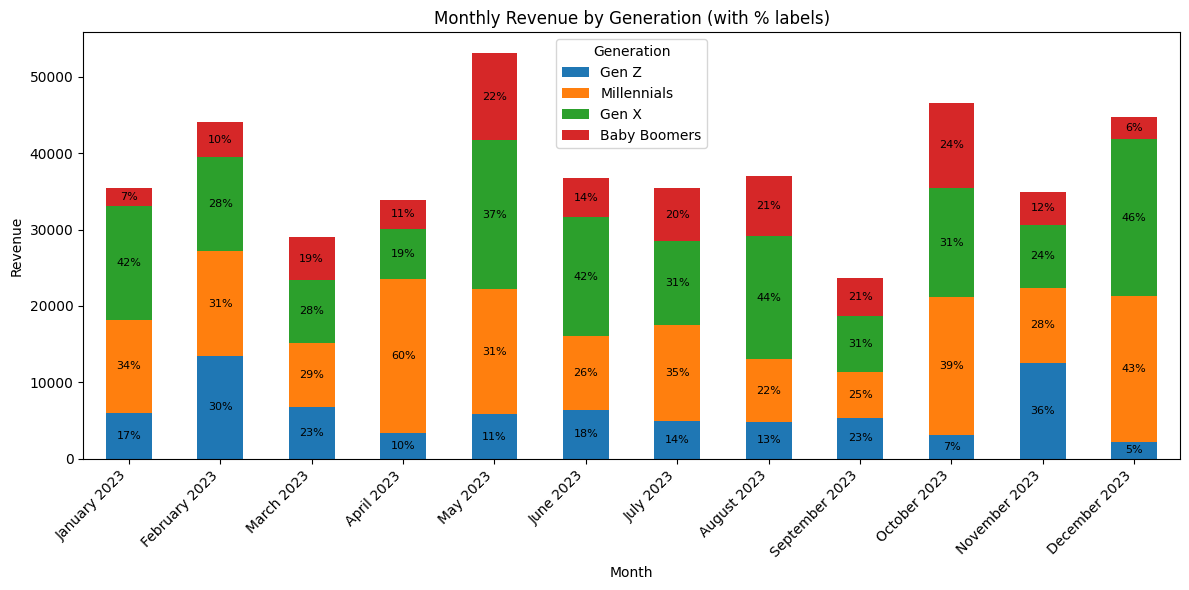

In [32]:
# Replot age group revenue by generation

# 1) Pivot monthly revenue by Generation
monthly_gen = df.pivot_table(
    index=pd.Grouper(freq='M'),
    columns='Generation',
    values='Total Amount',
    aggfunc='sum',
    fill_value=0
)
monthly_gen.index = monthly_gen.index.strftime('%B %Y')

# 2) Compute percentage contribution per month
monthly_pct = monthly_gen.div(monthly_gen.sum(axis=1), axis=0) * 100

# 3) Plot
fig, ax = plt.subplots(figsize=(12, 6))
monthly_gen.plot(kind='bar', stacked=True, ax=ax)

# 4) Annotate each segment
for container, gen in zip(ax.containers, monthly_gen.columns):
    for bar, pct in zip(container, monthly_pct[gen]):
        if bar.get_height() > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_y() + bar.get_height() / 2,
                f"{pct:.0f}%",
                ha='center', va='center', fontsize=8
            )

ax.set_title('Monthly Revenue by Generation (with % labels)')
ax.set_xlabel('Month')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [15]:
# Check new dtypes
dtypes = df.dtypes
print(dtypes)   

Transaction ID         int64
Customer ID           object
Gender                object
Age                    int64
Product Category      object
Quantity               int64
Price per Unit         int64
Total Amount           int64
Year                   int32
Month                  int32
Day                    int32
Day of Week            int32
Is Weekend              bool
Season              category
Generation          category
dtype: object


In [38]:

from datetime import date

# 1. Define 2023 Canadian statutory holidays
canada_holidays_2023 = {
    date(2023, 1, 1):  "New Year’s Day",
    date(2023, 2, 20): "Family Day",
    date(2023, 4, 7):  "Good Friday",
    date(2023, 5, 22): "Victoria Day",
    date(2023, 7, 1):  "Canada Day",
    date(2023, 8, 7):  "Civic Holiday",
    date(2023, 9, 4):  "Labour Day",
    date(2023, 10, 9): "Thanksgiving",
    date(2023, 12, 25):"Christmas Day",
    date(2023, 12, 26):"Boxing Day"
}

# 2. Map the index dates to holiday names
df['Holiday'] = (
    pd.Series(df.index.date, index=df.index)
      .map(canada_holidays_2023)
)

# 3. (Optional) If you still want a Boolean flag
df['IsHoliday'] = df['Holiday'].notna()

# 4. Peek at the flagged dates
holiday_df = df[df['Holiday'].notna()]
print(holiday_df[['Holiday']].drop_duplicates())

                   Holiday
Date                      
2023-12-26      Boxing Day
2023-07-01      Canada Day
2023-01-01  New Year’s Day
2023-10-09    Thanksgiving
2023-02-20      Family Day
2023-09-04      Labour Day
2023-05-22    Victoria Day
2023-08-07   Civic Holiday
2023-12-25   Christmas Day


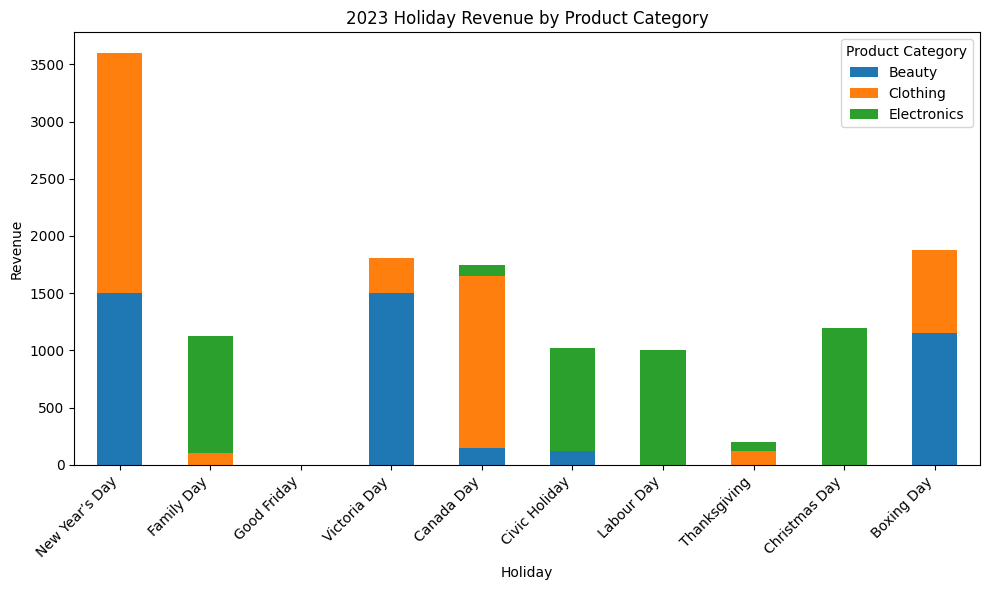

In [41]:

# Filter to holiday transactions
df_hol = df[df['Holiday'].notna()]

# Pivot: holidays × product categories
hol_pc = df_hol.pivot_table(
    index='Holiday',
    columns='Product Category',
    values='Total Amount',
    aggfunc='sum',
    fill_value=0
)

# Order holidays chronologically
holiday_order = [
    "New Year’s Day", "Family Day", "Good Friday", "Victoria Day",
    "Canada Day", "Civic Holiday", "Labour Day", "Thanksgiving",
    "Christmas Day", "Boxing Day"
]
hol_pc = hol_pc.reindex(holiday_order)

# Plot stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))
hol_pc.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('2023 Holiday Revenue by Product Category')
ax.set_xlabel('Holiday')
ax.set_ylabel('Revenue')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/2022646219.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_hol.groupby(['Holiday', 'Product Category', 'AgeGroup'])['Total Amount'] \


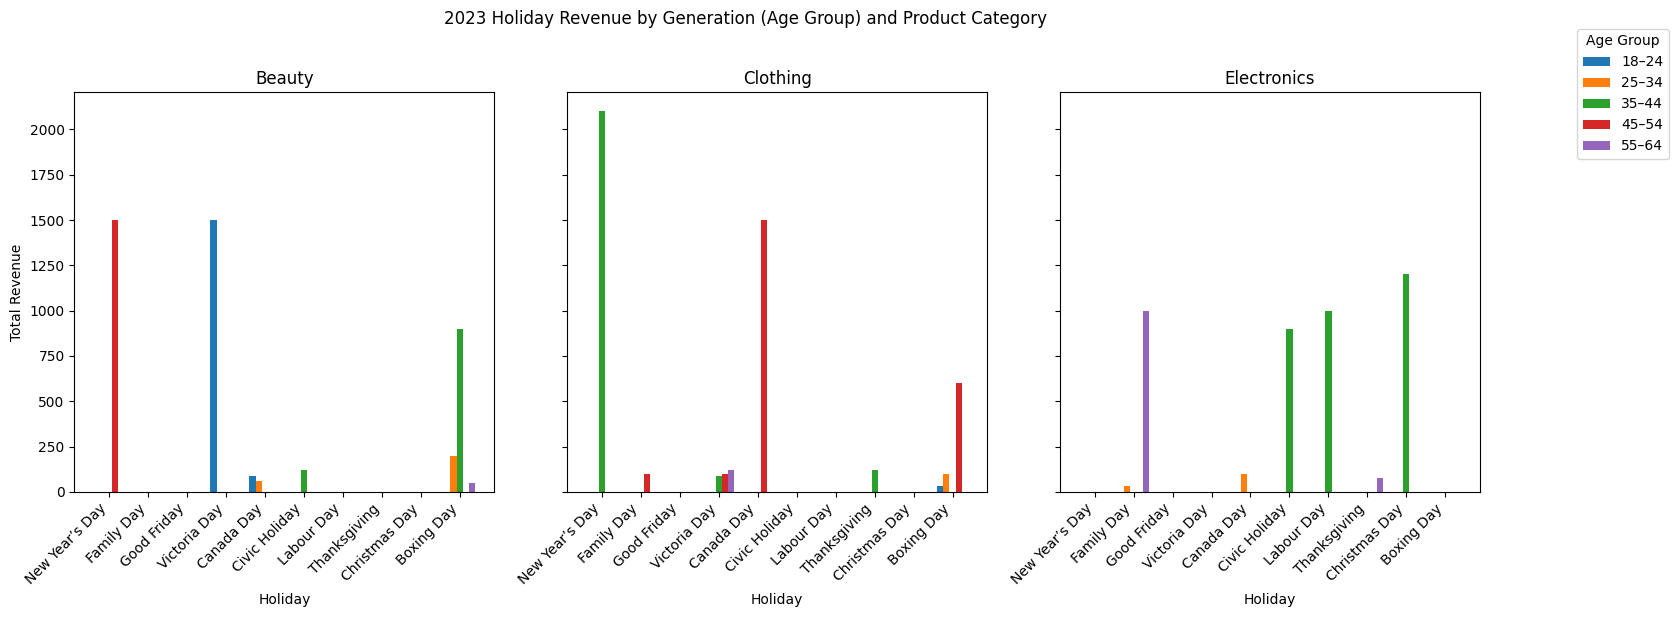

In [ ]:
# Plot revenue by holiday, product category, and age group to identify trends that will drive promotional strategies

# 1. Filter to holiday transactions
df_hol = df[df['Holiday'].notna()]

# 2. Aggregate revenue by Holiday, Product Category, and AgeGroup
df_grouped = df_hol.groupby(['Holiday', 'Product Category', 'AgeGroup'])['Total Amount'] \
                   .sum().reset_index()

# 3. Define holiday order
holiday_order = [
    "New Year’s Day", "Family Day", "Good Friday", "Victoria Day",
    "Canada Day", "Civic Holiday", "Labour Day", "Thanksgiving",
    "Christmas Day", "Boxing Day"
]

# 4. Plot setup: one subplot per product category
categories = df_grouped['Product Category'].unique()
age_groups = df_grouped['AgeGroup'].cat.categories
x = np.arange(len(holiday_order))
width = 0.8 / len(age_groups)

fig, axes = plt.subplots(1, len(categories), figsize=(5 * len(categories), 6), sharey=True)

for ax, category in zip(axes, categories):
    sub = df_grouped[df_grouped['Product Category'] == category]
    for i, age in enumerate(age_groups):
        values = [
            sub[(sub['Holiday'] == hol) & (sub['AgeGroup'] == age)]['Total Amount'].sum()
            for hol in holiday_order
        ]
        ax.bar(x + i * width, values, width, label=age)
    ax.set_xticks(x + width * (len(age_groups) - 1) / 2)
    ax.set_xticklabels(holiday_order, rotation=45, ha='right')
    ax.set_title(category)
    ax.set_xlabel('Holiday')

axes[0].set_ylabel('Total Revenue')
fig.legend(age_groups, title='Age Group', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('2023 Holiday Revenue by Generation (Age Group) and Product Category', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/859045539.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df


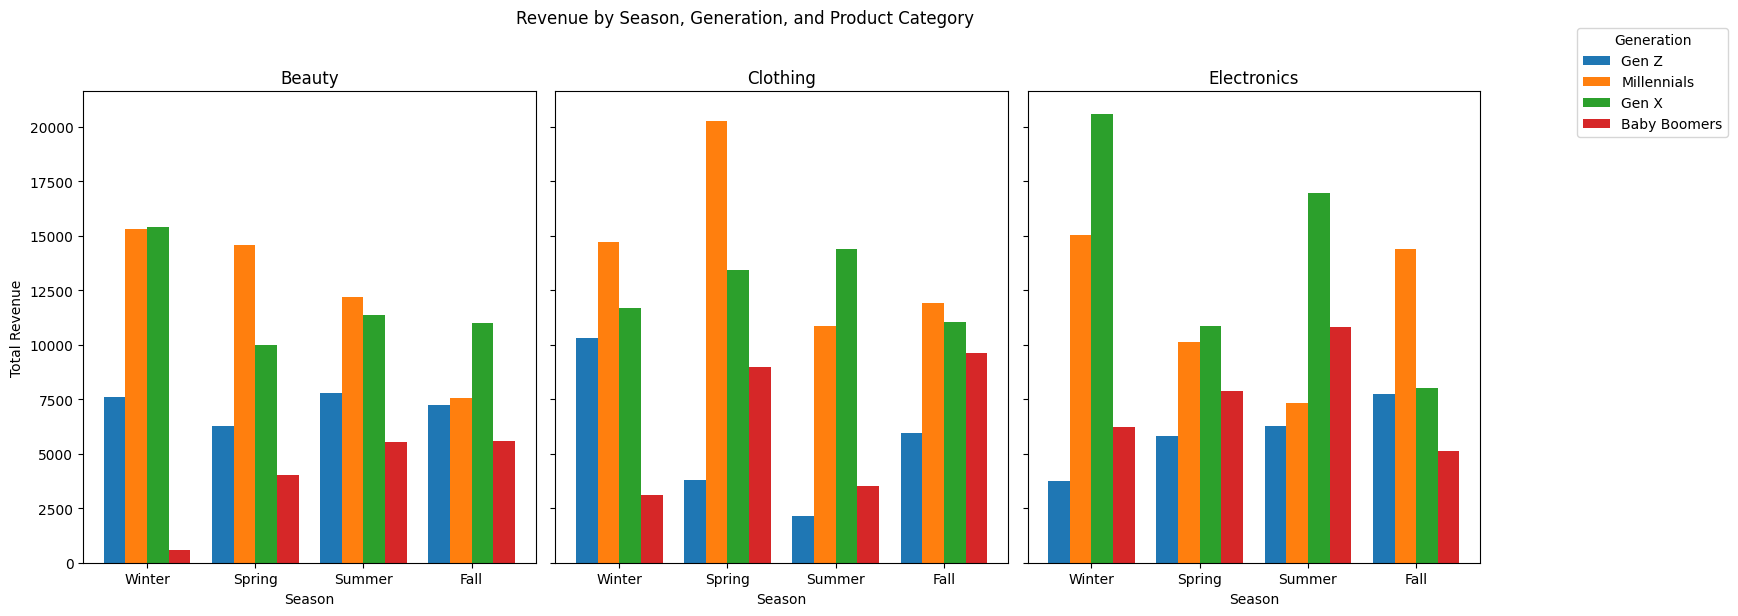

In [44]:


# 1. Aggregate revenue by Season, Product Category, and Generation
df_season = (
    df
    .groupby(['Season', 'Product Category', 'Generation'])['Total Amount']
    .sum()
    .reset_index()
)

# 2. Define season order, categories, and generations
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
categories   = df['Product Category'].unique()
generations  = df['Generation'].cat.categories

# 3. Plot setup: one subplot per product category
x = np.arange(len(season_order))
width = 0.8 / len(generations)

fig, axes = plt.subplots(1, len(categories), figsize=(5 * len(categories), 6), sharey=True)

for ax, category in zip(axes, categories):
    sub = df_season[df_season['Product Category'] == category]
    for i, gen in enumerate(generations):
        values = [
            sub[(sub['Season'] == season) & (sub['Generation'] == gen)]['Total Amount'].sum()
            for season in season_order
        ]
        ax.bar(x + i * width, values, width, label=gen)
    
    ax.set_xticks(x + width * (len(generations) - 1) / 2)
    ax.set_xticklabels(season_order)
    ax.set_title(category)
    ax.set_xlabel('Season')

axes[0].set_ylabel('Total Revenue')
fig.legend(generations, title='Generation', bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle('Revenue by Season, Generation, and Product Category', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/2718543361.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['Product Category'] == cat]
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/2718543361.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[df['Product Category'] == cat]
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/2718543361.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defau

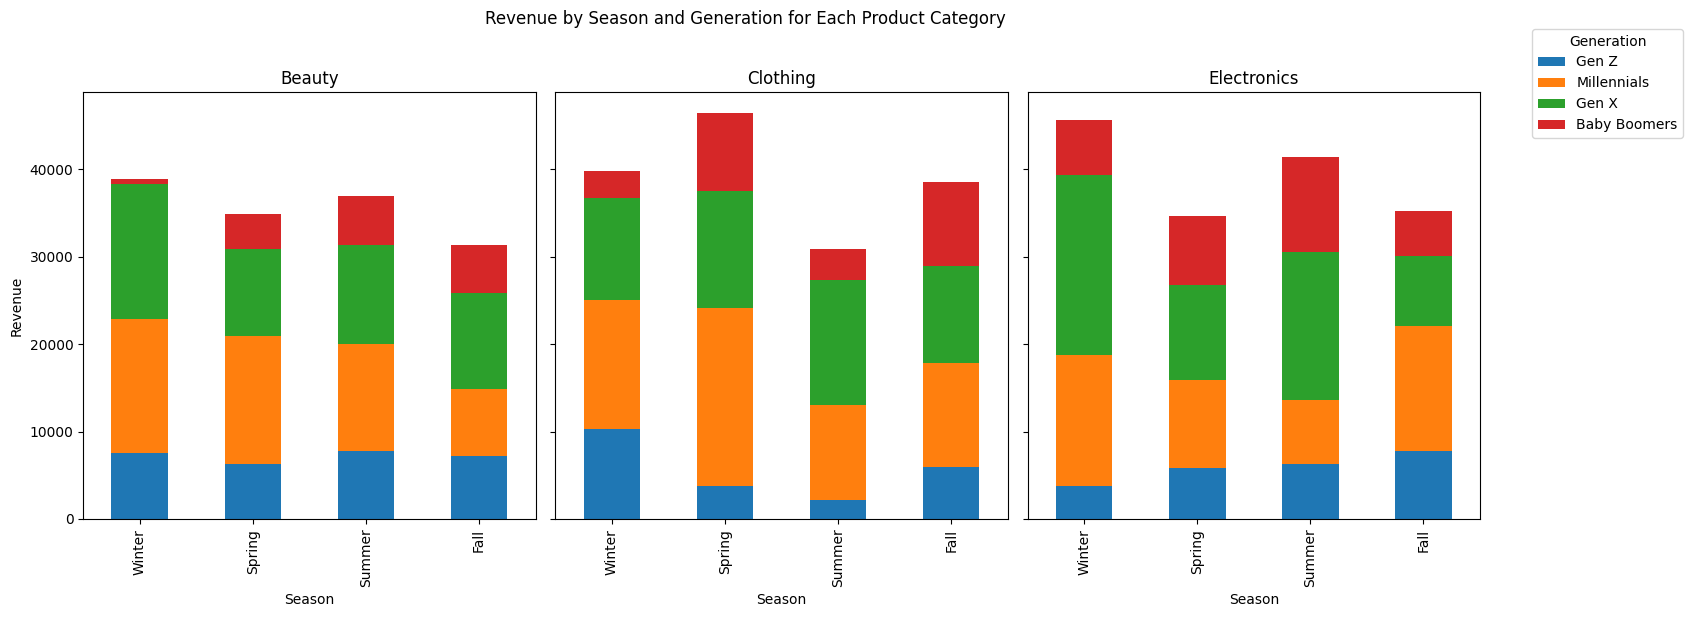

In [45]:


# 1. Define orderings
categories   = df['Product Category'].unique()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# 2. Create subplots, one per category
fig, axes = plt.subplots(1, len(categories), figsize=(5 * len(categories), 6), sharey=True)

for ax, cat in zip(axes, categories):
    # Pivot seasons × generations for this category
    pivot = (
        df[df['Product Category'] == cat]
        .groupby(['Season', 'Generation'])['Total Amount']
        .sum()
        .unstack(fill_value=0)
        .reindex(season_order)
    )
    # Plot a stacked bar chart
    pivot.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(cat)
    ax.set_xlabel('Season')
    ax.set_ylabel('Revenue')
    ax.legend().remove()  # Hide per-axis legend

# 3. Shared legend for generations
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Generation', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.suptitle('Revenue by Season and Generation for Each Product Category', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/955129222.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[(df['Product Category'] == cat) & (df['Generation'].isin(selected_gens))]
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/955129222.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[(df['Product Category'] == cat) & (df['Generation'].isin(selected_gens))]
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/955129222.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass o

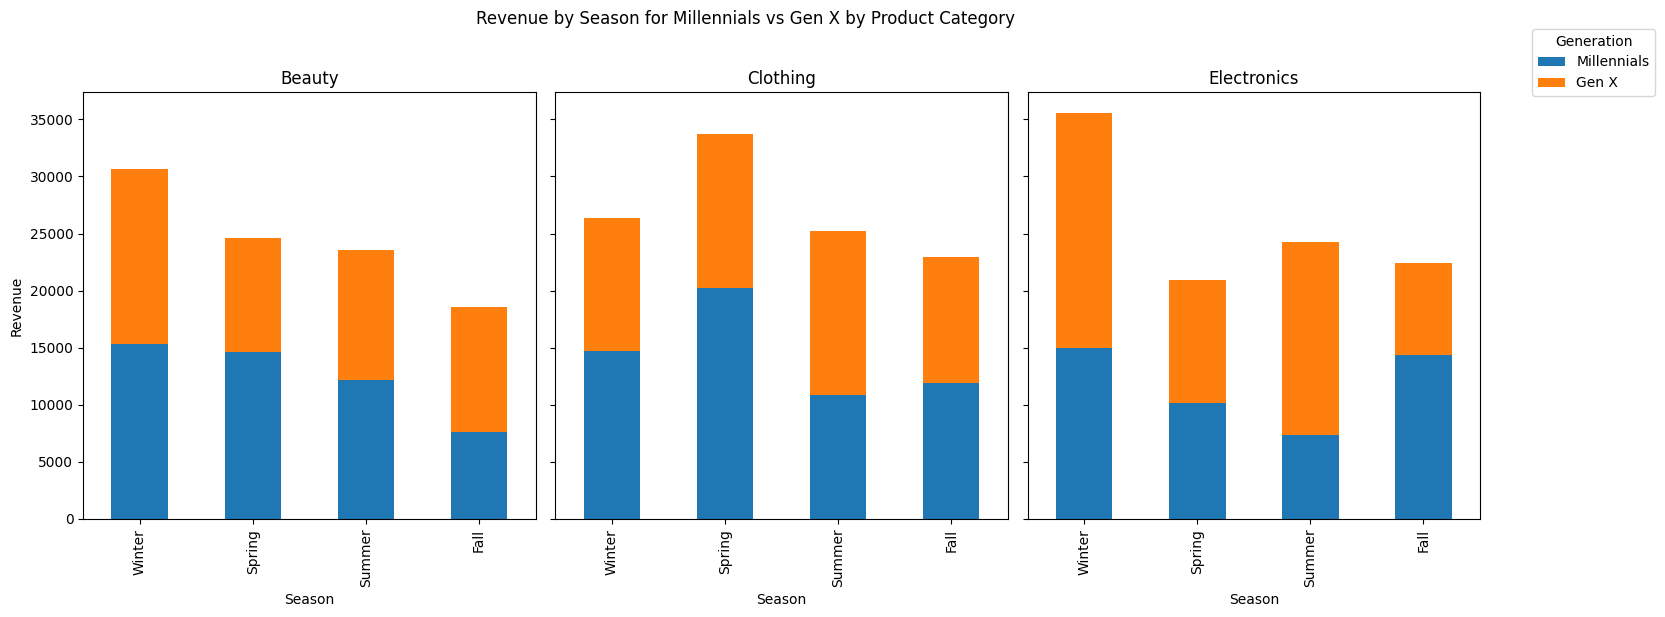

In [ ]:

# Stratifying two generations (drivers) vs season
# 1. Define the two generations to compare
selected_gens = ['Millennials', 'Gen X']
categories   = df['Product Category'].unique()
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

# 2. Create subplots, one per category
fig, axes = plt.subplots(1, len(categories), figsize=(5 * len(categories), 6), sharey=True)

for ax, cat in zip(axes, categories):
    # Filter to only the two generations
    pivot = (
        df[(df['Product Category'] == cat) & (df['Generation'].isin(selected_gens))]
        .groupby(['Season', 'Generation'])['Total Amount']
        .sum()
        .unstack(fill_value=0)
        .reindex(season_order)
    )
    # Plot stacked bar chart for the two generations
    pivot[selected_gens].plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(cat)
    ax.set_xlabel('Season')
    ax.set_ylabel('Revenue')
    ax.legend().remove()  # Hide per-axis legend

# 3. Shared legend for the two generations
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Generation', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.suptitle('Revenue by Season for Millennials vs Gen X by Product Category', y=1.02)
plt.tight_layout()
plt.show()

/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/1129010386.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/1129010386.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub
/var/folders/6h/q4ysnrk935x4j8pjrr_90hg00000gn/T/ipykernel_27400/1129010386.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sub


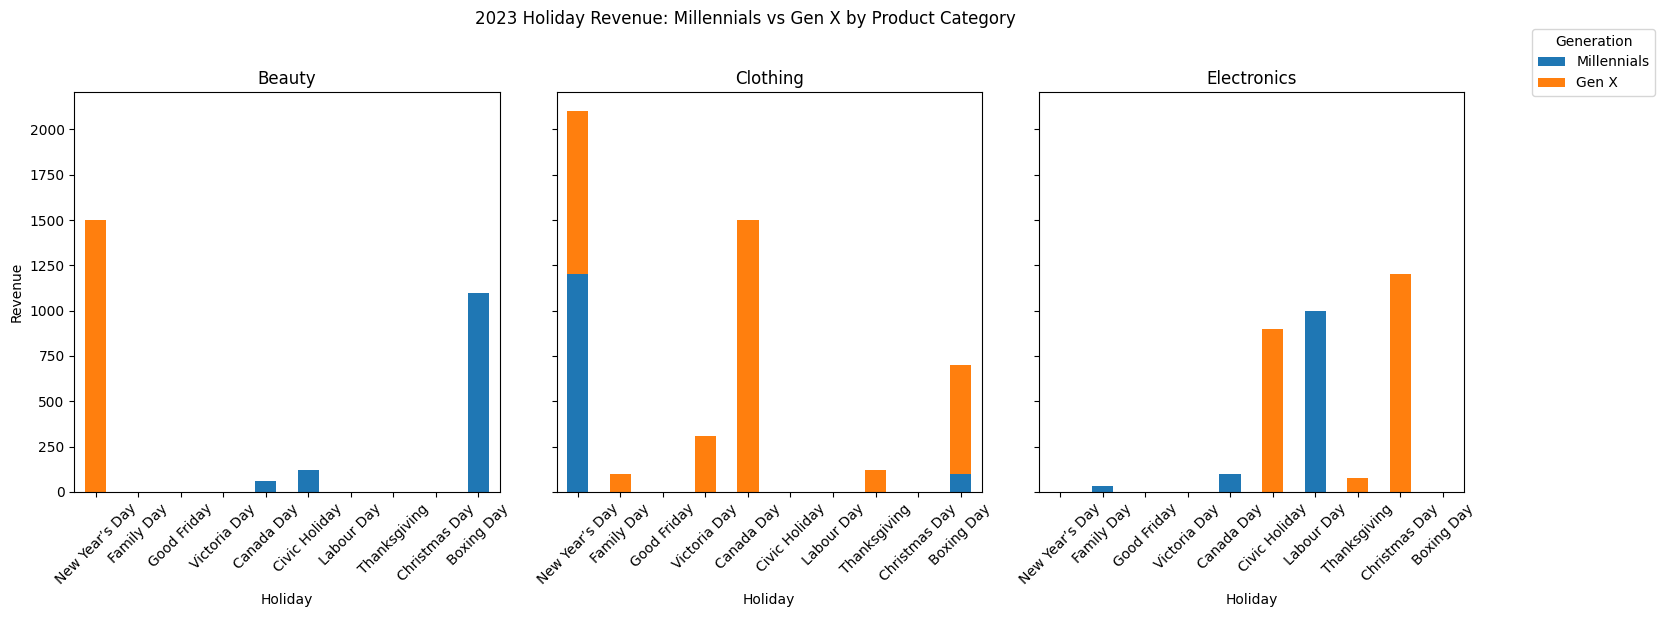

In [ ]:
# Stratifying only by two generations (Millennials and Gen X) for holiday revenue by product category to identify drivers

# 1. Generations to compare
selected_gens = ['Millennials', 'Gen X']
categories   = df['Product Category'].unique()

# 2. Chronological holiday order
holiday_order = [
    "New Year’s Day", "Family Day", "Good Friday", "Victoria Day",
    "Canada Day", "Civic Holiday", "Labour Day", "Thanksgiving",
    "Christmas Day", "Boxing Day"
]

# 3. Plot setup: one subplot per product category
fig, axes = plt.subplots(1, len(categories), figsize=(5 * len(categories), 6), sharey=True)

for ax, cat in zip(axes, categories):
    # Filter to this category and known holidays
    sub = df[df['Holiday'].isin(holiday_order) & (df['Product Category'] == cat)]
    # Pivot holiday × generation
    pivot = (
        sub
        .groupby(['Holiday', 'Generation'])['Total Amount']
        .sum()
        .unstack(fill_value=0)
        .reindex(holiday_order)
    )
    # Plot stacked bars for Millennials and Gen X
    pivot[selected_gens].plot(kind='bar', stacked=True, ax=ax)
    ax.set_title(cat)
    ax.set_xlabel('Holiday')
    ax.set_ylabel('Revenue')
    ax.tick_params(axis='x', rotation=45)
    ax.legend().remove()

# 4. Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Generation', bbox_to_anchor=(1.02, 1), loc='upper left')

plt.suptitle('2023 Holiday Revenue: Millennials vs Gen X by Product Category', y=1.02)
plt.tight_layout()
plt.show()